<a href="https://colab.research.google.com/github/yrodriguezmd/Surgical_instruments/blob/main/Sets/Set_S/notebooks/Set_1_2_Model_B_ret_epoch100_oct15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Started training for epochs = 100 from Model A_.

Use Set_1_2 merged dataset, annotated, split in train/valid/test.

Train Model_A_ using Set_1_2 to generate Model_B_.

In [ ]:
!wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
!bash install_colab.sh

In [2]:
exit()

In [ ]:
import icevision

In [2]:
from icevision.all import *
print('icevision v',icevision.__version__)
print('torch v',torch.__version__)
print('torchvision v',torchvision.__version__)

icevision v 0.10.0a1
torch v 1.9.0+cu111
torchvision v 0.10.0+cu111


Use annotated Set_1

In [3]:
! git clone https://github.com/yrodriguezmd/Surgical_instruments.git

Cloning into 'Surgical_instruments'...
remote: Enumerating objects: 1779, done.
remote: Counting objects: 100% (295/295), done.
remote: Compressing objects: 100% (286/286), done.
remote: Total 1779 (delta 90), reused 7 (delta 7), pack-reused 1484
Receiving objects: 100% (1779/1779), 54.79 MiB | 29.07 MiB/s, done.
Resolving deltas: 100% (309/309), done.


In [159]:
!ls Surgical_instruments/Sets/Set_S/annotated
# merged dataset in Set_S contains Set_1 and Set_2

README.md  test  train	valid


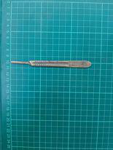

In [160]:
image_path = Path('Surgical_instruments/Sets/Set_S/annotated/train')

img_files = get_image_files(image_path)

img = PIL.Image.open(img_files[101]) ##
img = img.convert('RGB')

img.to_thumb(150,150)

In [161]:
classes = ['Towel_clip', 'Castroviejo', 'Yankauer', 'Hemostat', 'Army_navy', 'Richardson', 'Potts', 'Iris', 'Bulldog', 'Forceps', 'Scalpel', 'Frazier', 'Needle', 'Weitlaner', 'Mayo_metz']
class_map = ClassMap(classes)
len(class_map)

16

Parse data

In [167]:
!ls Surgical_instruments/Sets/Set_S/annotations/train

README.md  Set_1_2_annotations.coco.json


In [169]:
path = Path('Surgical_instruments/Sets/Set_S/') # adjust if use git clone vs gdrive

train_parser = parsers.COCOBBoxParser(
    annotations_filepath = path/'annotations/train/Set_1_2_annotations.coco.json',
    img_dir = path/'annotated/train'
)

valid_parser = parsers.COCOBBoxParser(
    annotations_filepath = path/'annotations/valid/Set_1_2_annotations.coco.json',
    img_dir = path/'annotated/valid'
)

In [170]:
# dataset already split in annotation tool, maintain grouping

whole = SingleSplitSplitter()

train_records, *_ = train_parser.parse(data_splitter = whole)

valid_records, *_ = valid_parser.parse(data_splitter = whole)

  0%|          | 0/212 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/56 [00:00<?, ?it/s]

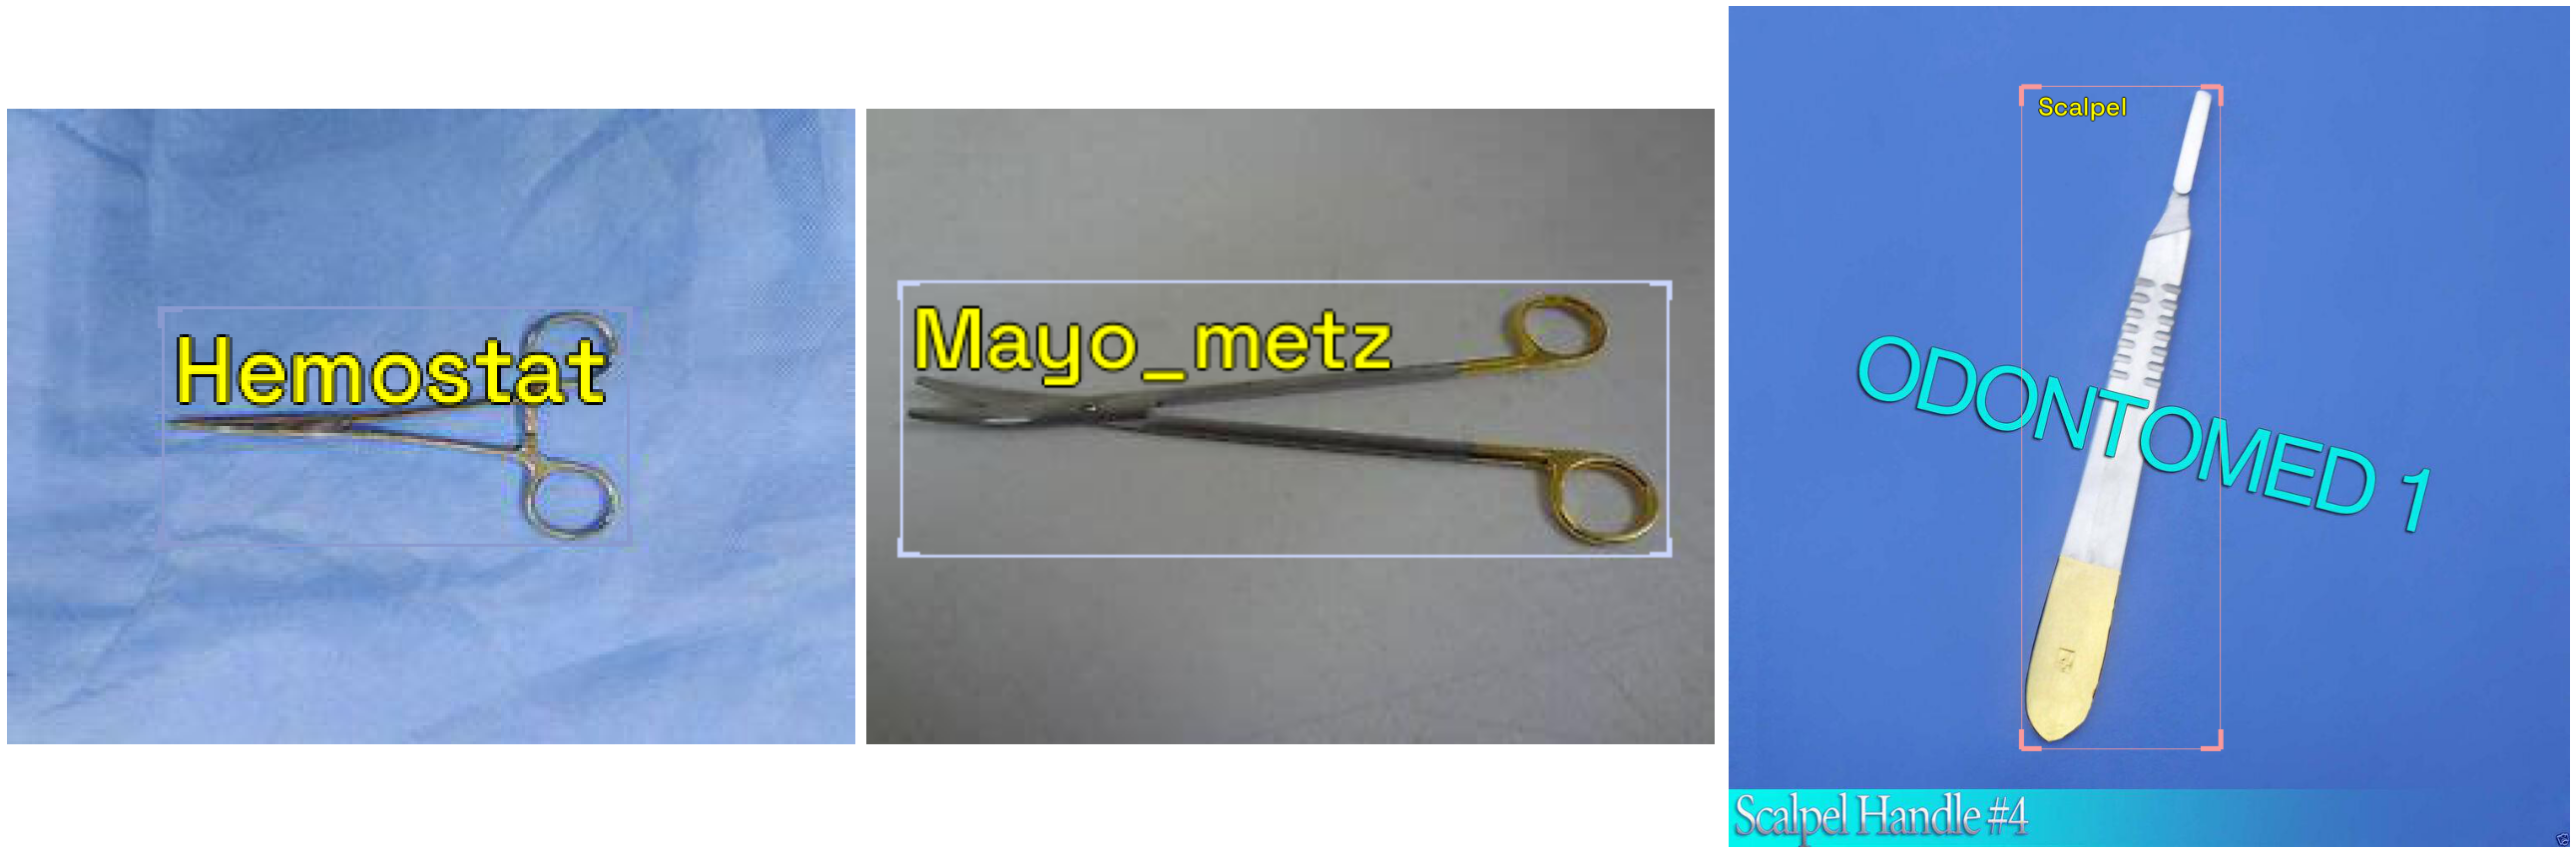

In [171]:
show_records(train_records[0:3],ncols=3, font_size=30, label_color = '#ffff00')

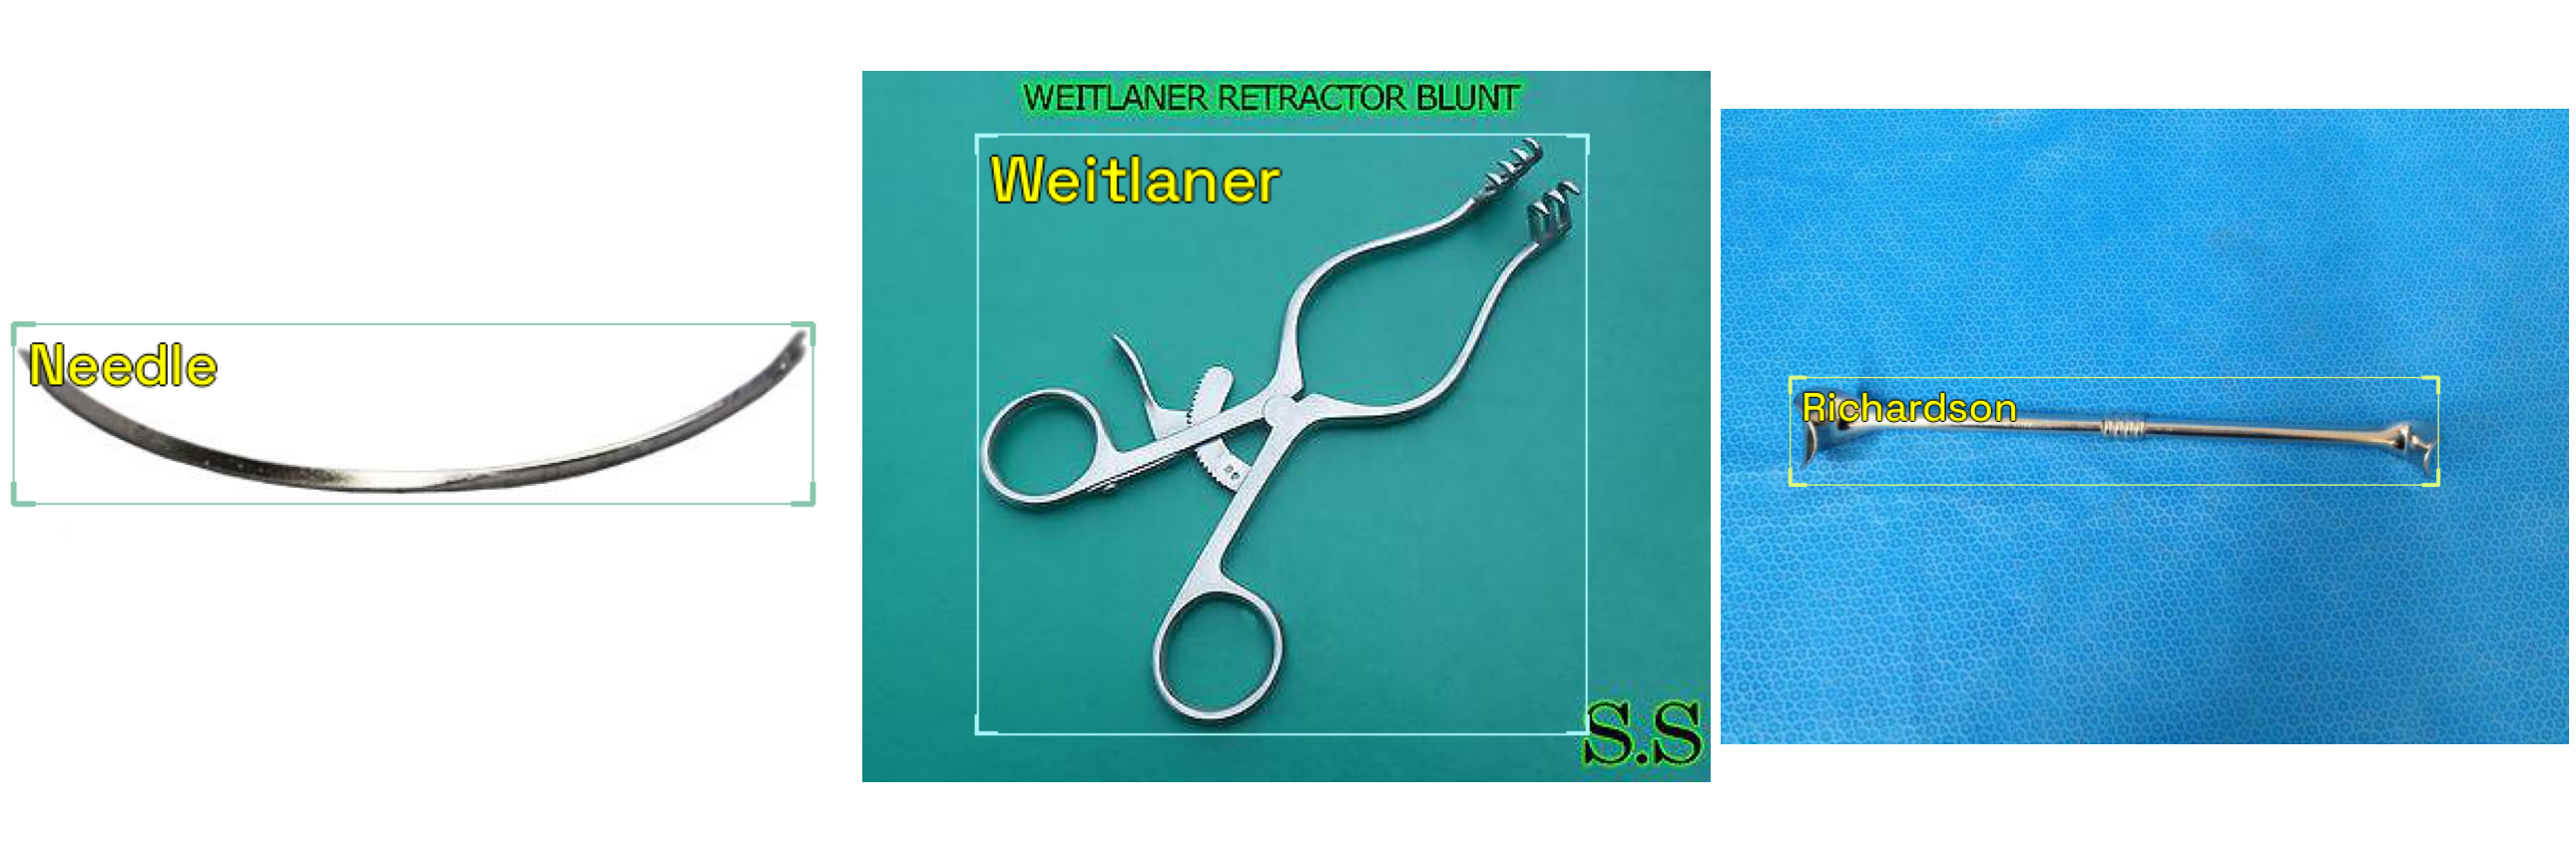

In [172]:
show_records(valid_records[0:3],ncols=3, font_size=30, label_color = '#ffff00')

In [173]:
presize = 512
image_size = 384

train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=presize), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=image_size), tfms.A.Normalize()])

In [174]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

Train Model_A_ to generate teacher Model B_ using Set_1_2 merged.  

In [175]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

from icevision.models.checkpoint import *

model_type = models.mmdet.retinanet ##
backbone = model_type.backbones.resnet50_fpn_1x##

#model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(classes),)# **extra_args)

In [ ]:
checkpoint_path = 'Model_A__ret_mAP42.7.pth'

checkpoint_and_model = model_from_checkpoint(checkpoint_path)

model = checkpoint_and_model['model']
model.train()

In [177]:
train_dl = model_type.train_dl(train_ds, batch_size = 16, num_workers = 4,
                               shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=16, num_workers = 4,
                               shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
##
from fastai.callback.wandb import *

wandb.init(project = 'Surgical_instruments', name = 'Model_B_Set_1_2', reinit = True)

In [179]:
learn = model_type.fastai.learner(dls = [train_dl, valid_dl],
                                  model = model, metrics = metrics,#)
                                  cbs = WandbCallback()) ##

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


SuggestedLRs(valley=6.30957365501672e-05)

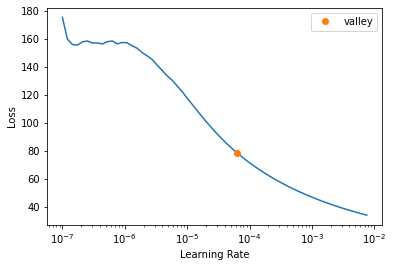

In [180]:
learn.lr_find()

In [181]:
# Set 1_2, retinanet, 
learn.fine_tune(100,1e-4)

Could not gather input dimensions
WandbCallback requires use of "SaveModelCallback" to log best model
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'Dataset' object has no attribute 'items'


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


Could not gather input dimensions


In [20]:
import matplotlib.pyplot as plt
def plot_metrics(learn, title):
  plt.plot(L(learn.recorder.values).itemgot())
  plt.xlabel('epoch')
  plt.ylabel('mAP (green), Loss (blue, orange)')
  plt.title(title)
  plt.text(0,-0.2, 
       'Legend: mAP(green), train_loss(blue), valid_loss(orange')
  plt.ylim(0,1);

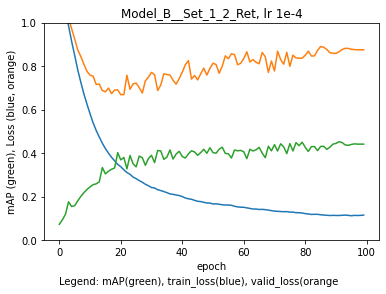

In [182]:
plot_metrics(learn, 'Model_B__Set_1_2_Ret, lr 1e-4')

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


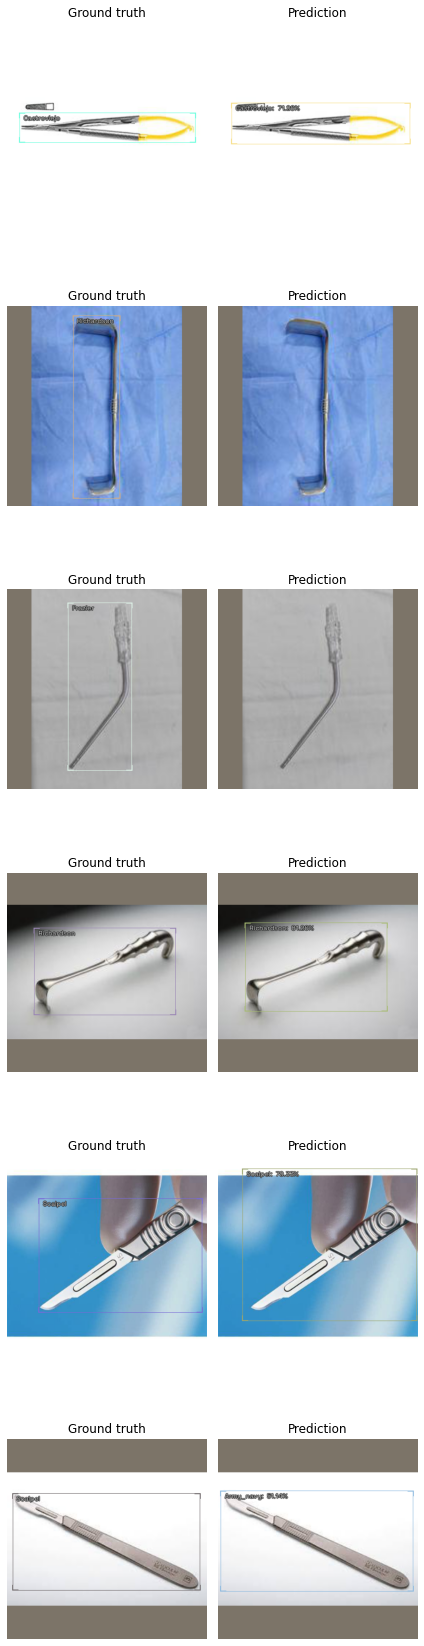

In [183]:
model_type.show_results(model, valid_ds)

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


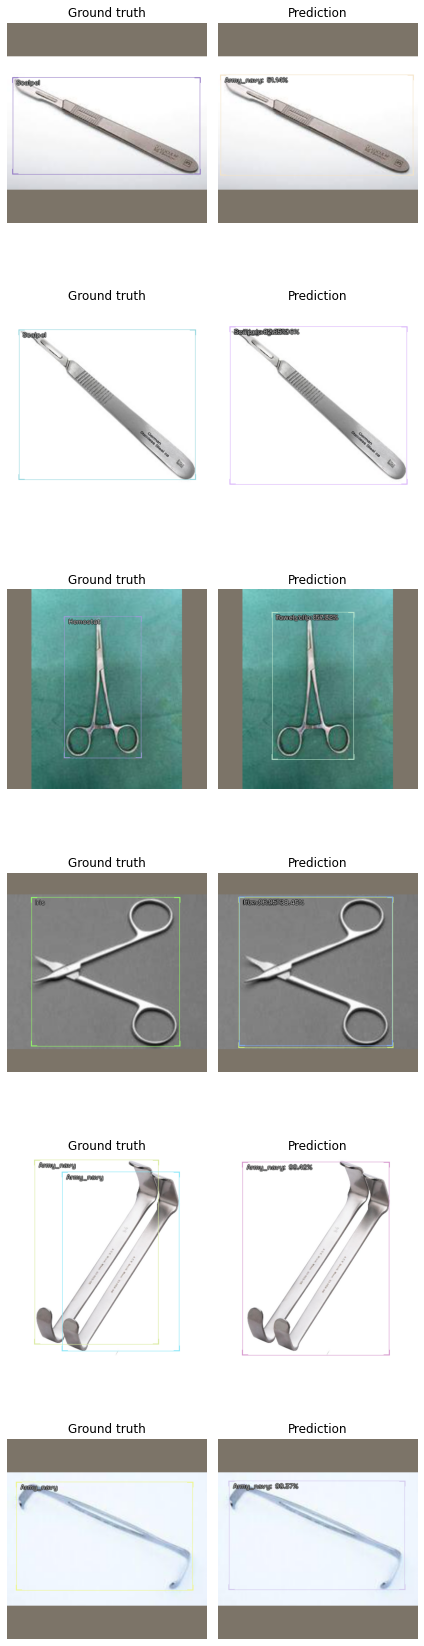

In [184]:
model_type.show_results(model, valid_ds)

In [185]:
from icevision.models import *

checkpoint_path = 'Model_B__ret_mAP44.3.pth'

save_icevision_checkpoint(model, 
                        model_name='mmdet.retinanet', 
                        backbone_name='resnet50_fpn_1x',
                        classes =  train_parser.class_map.get_classes(), 
                        img_size=image_size, 
                        filename=checkpoint_path,
                        meta={'icevision_version': '0.9.1'})

Inference for Set_3

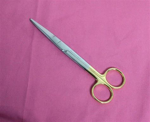

In [186]:
image_path = Path('Surgical_instruments/Sets/Set_3/raw_images')

img_files = get_image_files(image_path)

img = PIL.Image.open(img_files[0]) ##
img = img.convert('RGB')

img.to_thumb(150,150)

In [187]:
classes = ['Towel_clip', 'Castroviejo', 'Yankauer', 'Hemostat', 'Army_navy', 'Richardson', 'Potts', 'Iris', 'Bulldog', 'Forceps', 'Scalpel', 'Frazier', 'Needle', 'Weitlaner', 'Mayo_metz']
class_map = ClassMap(classes)

In [188]:
imgs_array = [PIL.Image.open(file) for file in img_files]

imgs_array = [image.convert('RGB') for image in imgs_array]

img_size = 384 

valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(img_size), tfms.A.Normalize()])

infer_ds = Dataset.from_images(imgs_array, valid_tfms, class_map = class_map)

Use Model B_ (trained on Set_1_2)

In [ ]:
from icevision.models import *

checkpoint_path = 'Model_B__ret_mAP44.3.pth'

checkpoint_and_model = model_from_checkpoint(checkpoint_path)
model = checkpoint_and_model['model'] # Model B
model.eval()

Inference/ generate pseudolabels for Set_2 using Model A_.

In [190]:
infer_dl = model_type.infer_dl(infer_ds, batch_size=4, shuffle=False)

preds_saved = model_type.predict_from_dl(model, infer_dl,
                                          keep_images=True, 
                                         detection_threshold = 0.5) ##

  0%|          | 0/38 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


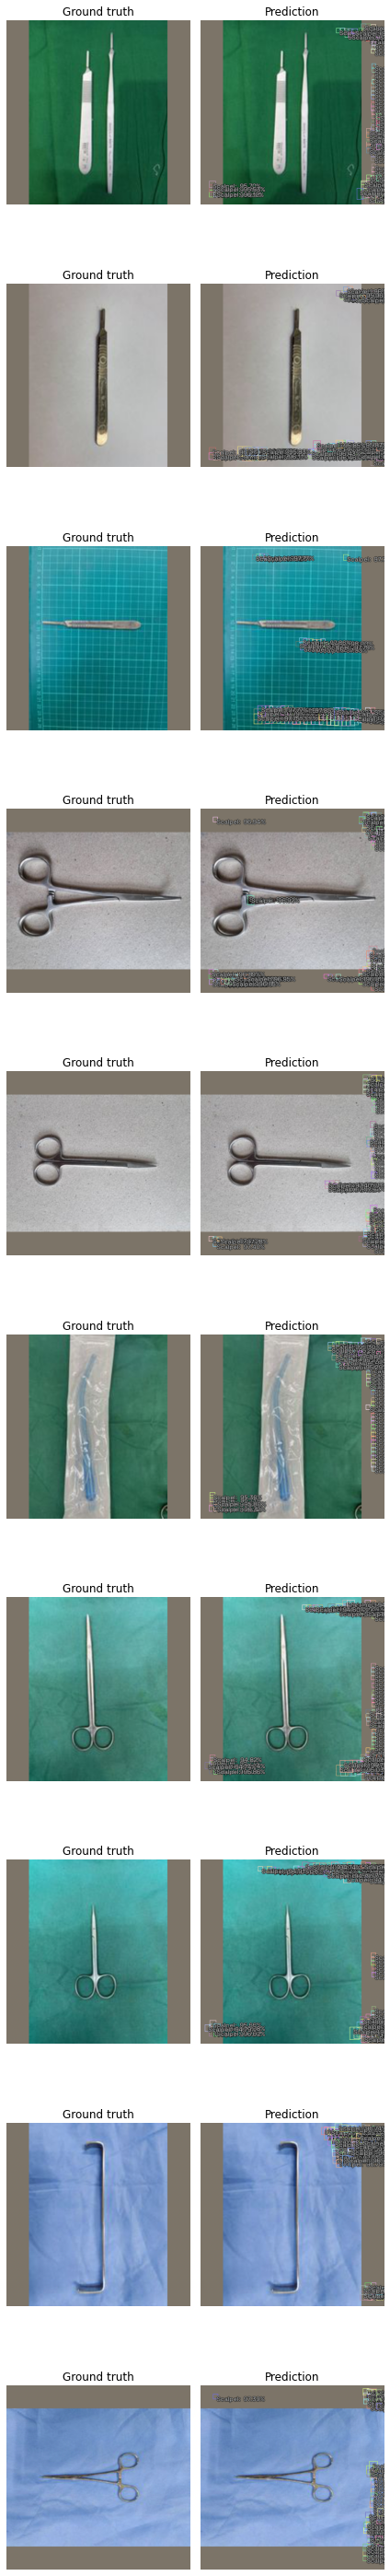

In [157]:
show_preds(preds = preds_saved[0:10])
# with detection threshold 0.5

Poor pseudolabels.

Annotate and split in Roboflow.

Continue iterative training.